In [11]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [12]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [13]:
!pip install catboost

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# from category_encoders import CatBoostEncoder

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

#text preproccessing
import nltk
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS

# plt
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [16]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [17]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
PYTHONHASHSEED = 0

In [18]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [19]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

# EDA

In [20]:
train.drop_duplicates(inplace=True)  # delete duplicates

Look at train data

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [22]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [23]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

Look at test data

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1671 entries, 0 to 1670
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              1671 non-null   object
 1   brand                 1671 non-null   object
 2   color                 1671 non-null   object
 3   description           1671 non-null   object
 4   engineDisplacement    1671 non-null   object
 5   enginePower           1671 non-null   object
 6   fuelType              1671 non-null   object
 7   mileage               1671 non-null   int64 
 8   modelDate             1671 non-null   int64 
 9   model_info            1671 non-null   object
 10  name                  1671 non-null   object
 11  numberOfDoors         1671 non-null   int64 
 12  productionDate        1671 non-null   int64 
 13  sell_id               1671 non-null   int64 
 14  vehicleConfiguration  1671 non-null   object
 15  vehicleTransmission   1671 non-null   

In [25]:
test.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                1092
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [26]:
test.nunique()

bodyType                  14
brand                      3
color                     15
description             1540
engineDisplacement        43
enginePower              120
fuelType                   4
mileage                  935
modelDate                 37
model_info               101
name                     536
numberOfDoors              4
productionDate            35
sell_id                 1671
vehicleConfiguration     205
vehicleTransmission        4
Владельцы                  3
Владение                 131
ПТС                        2
Привод                     3
Руль                       1
dtype: int64

Only 2 columns with nan in train and 1 column in test.

Delete nan from column 'Владельцы'

In [27]:
nan = ['Владельцы']
train.dropna(subset=nan, inplace=True)

In [28]:
train.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  0
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

Let's look at the data in detail

In [29]:
train['bodyType'].value_counts(dropna=False)

седан                   2842
внедорожник 5 дв.       2315
купе                     427
хэтчбек 5 дв.            296
лифтбек                  245
универсал 5 дв.          153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 44
хэтчбек 3 дв.             41
компактвэн                 8
лимузин                    5
внедорожник 3 дв.          3
внедорожник открытый       2
пикап двойная кабина       2
седан 2 дв.                1
Name: bodyType, dtype: int64

In [30]:
train['bodyType'].str.partition()[0].value_counts(dropna=False)

седан           2843
внедорожник     2320
купе             427
хэтчбек          337
лифтбек          245
универсал        153
минивэн          146
купе-хардтоп      91
родстер           60
кабриолет         44
компактвэн         8
лимузин            5
пикап              2
Name: 0, dtype: int64

In [31]:
test['bodyType'].value_counts(dropna=False)

седан                   698
внедорожник 5 дв.       581
купе                    116
хэтчбек 5 дв.            68
лифтбек                  54
универсал 5 дв.          43
минивэн                  32
родстер                  28
купе-хардтоп             20
хэтчбек 3 дв.            16
кабриолет                10
внедорожник открытый      2
внедорожник 3 дв.         2
пикап двойная кабина      1
Name: bodyType, dtype: int64

In [32]:
test['bodyType'].str.partition()[0].value_counts(dropna=False)

седан           698
внедорожник     585
купе            116
хэтчбек          84
лифтбек          54
универсал        43
минивэн          32
родстер          28
купе-хардтоп     20
кабриолет        10
пикап             1
Name: 0, dtype: int64

In [33]:
train['brand'].value_counts(dropna=False)

BMW         2805
MERCEDES    2294
AUDI        1582
Name: brand, dtype: int64

In [34]:
test['brand'].value_counts(dropna=False)

BMW         730
MERCEDES    552
AUDI        389
Name: brand, dtype: int64

In [35]:
train['color'].value_counts(dropna=False)

чёрный         2804
белый          1263
серый           733
синий           685
серебристый     341
коричневый      307
красный         203
бежевый          76
голубой          72
зелёный          70
фиолетовый       37
пурпурный        30
оранжевый        22
золотистый       21
жёлтый           16
розовый           1
Name: color, dtype: int64

In [36]:
test['color'].value_counts(dropna=False)

чёрный         663
белый          344
серый          192
синий          178
серебристый     79
коричневый      79
красный         63
голубой         19
зелёный         16
фиолетовый       9
бежевый          9
оранжевый        8
пурпурный        8
золотистый       3
жёлтый           1
Name: color, dtype: int64

In [37]:
train['description'].value_counts(dropna=False)

Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудова

In [38]:
train['description'].str.replace(r'(\n|\t|\d|\r|\0)', '').value_counts()

Выгода до   руб. при обмене на Ваш автомобиль! Выгода при покупке в кредит до   руб.! РОЛЬФ ЯСЕНЕВО с пробегом. -Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. -В наличии более  проверенных и готовых к продаже автомобилей. -Более  комплектов шин, дисков, колес в сборе. -Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. -Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. -Мы работаем каждый день с : до : (без выходных). Услуги: • Срочный выкуп Вашего автомобиля • Выкуп кредитных а/м • Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) • Выездная оценка Вашего а/м • Комиссионная продажа (на Ваших условиях) • Аукцион • Кредитование • Страхование КАСКО, ОСАГО • Дополнительное оборудование • Запасные части • Сервисное обслуживание • Б/У шины и д

In [39]:
train['description'].str.replace(r'(\W|\d)', ' ').str.replace(r'(\s+)', ' ').value_counts()

Выгода до руб при обмене на Ваш автомобиль Выгода при покупке в кредит до руб РОЛЬФ ЯСЕНЕВО с пробегом Мы принимаем любые легковые и коммерческие автомобили независимо от марки года выпуска пробега и состояния автомобиля В наличии более проверенных и готовых к продаже автомобилей Более комплектов шин дисков колес в сборе Все автомобили проходят комплексную проверку техническую криминалистическую проверку истории кузовных ремонтов сертифицированными специалистами Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ Мы работаем каждый день с до без выходных Услуги Срочный выкуп Вашего автомобиля Выкуп кредитных а м Trade in обмен Вашего автомобиля на новый или с пробегом возможна доплата с любой стороны Выездная оценка Вашего а м Комиссионная продажа на Ваших условиях Аукцион Кредитование Страхование КАСКО ОСАГО Дополнительное оборудование Запасные части Сервисное обслуживание Б У шины и диски Более проверенных автомобилей с пробегом с гарантией до лет ждут

In [40]:
test['description'].value_counts(dropna=False)

Выгода до 82 000 руб. при обмене на Ваш автомобиль! \nВыгода при покупке в кредит до 100 000 руб.! \nРОЛЬФ ЯСЕНЕВО с пробегом. \n-Мы принимаем любые легковые и коммерческие автомобили независимо от марки, года выпуска, пробега и состояния автомобиля. \n-В наличии более 500 проверенных и готовых к продаже автомобилей. \n-Более 400 комплектов шин, дисков, колес в сборе. \n-Все автомобили проходят комплексную проверку - техническую, криминалистическую, проверку истории кузовных ремонтов сертифицированными специалистами. \n-Мы предоставляем гарантию юридической чистоты в соответствии с законодательством РФ. \n-Мы работаем каждый день с 9:00 до 22:00 (без выходных). \nУслуги: \n• Срочный выкуп Вашего автомобиля \n• Выкуп кредитных а/м \n• Trade-in - обмен Вашего автомобиля на новый или с пробегом (возможна доплата с любой стороны) \n• Выездная оценка Вашего а/м \n• Комиссионная продажа (на Ваших условиях) \n• Аукцион \n• Кредитование \n• Страхование КАСКО, ОСАГО \n• Дополнительное оборудова

In [41]:
train['engineDisplacement'].value_counts(dropna=False)

2.0 LTR          1929
3.0 LTR          1862
1.8 LTR           329
1.6 LTR           327
4.4 LTR           260
5.5 LTR           227
3.5 LTR           208
2.5 LTR           203
2.1 LTR           181
4.0 LTR           121
4.7 LTR           109
2.8 LTR            89
1.4 LTR            82
4.2 LTR            79
1.5 LTR            61
5.0 LTR            60
3.2 LTR            49
2.2 LTR            44
2.9 LTR            43
4.8 LTR            41
3.1 LTR            39
2.4 LTR            38
6.2 LTR            31
6.0 LTR            30
1.3 LTR            30
5.4 LTR            27
1.2 LTR            26
2.7 LTR            22
4.1 LTR            19
3.6 LTR            18
1.7 LTR            11
3.7 LTR            11
5.2 LTR            10
5.9 LTR            10
2.6 LTR             7
4.6 LTR             5
0.7 LTR             5
2.3 LTR             5
undefined LTR       5
3.4 LTR             4
1.9 LTR             4
6.6 LTR             4
5.6 LTR             3
4.3 LTR             3
5.8 LTR             3
6.3 LTR   

In [42]:
train[train['engineDisplacement'] == 'undefined LTR']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
2296,хэтчбек 5 дв.,BMW,чёрный,"Автомобиль в наличии Москве , с ПТС , производ...",undefined LTR,184 N12,электро,9000,2017,I3,...,2719000.0,2019,1100083262,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
3725,хэтчбек 5 дв.,BMW,чёрный,"BMW i3 Электромобиль с бензиновым генератором,...",undefined LTR,170 N12,электро,39500,2017,I3,...,2299711.0,2017,1098041130,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,2 года и 11 месяцев,Оригинал,задний,Левый
3726,хэтчбек 5 дв.,BMW,голубой,Прибыло из Америки в августе 20 года. Полная и...,undefined LTR,170 N12,электро,28800,2017,I3,...,2170000.0,2017,1100097316,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
5862,хэтчбек 5 дв.,BMW,белый,В наличии! Автомобиль куплен в США! Комплектац...,undefined LTR,170 N12,электро,35810,2013,I3,...,1690000.0,2016,1100153696,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый
6283,хэтчбек 5 дв.,BMW,чёрный,Авто в идеальном состоянии\nЕсть REX (range ex...,undefined LTR,170 N12,электро,60000,2013,I3,...,1790000.0,2015,1097395090,HATCHBACK_5_DOORS AUTOMATIC,автоматическая,1 владелец,NaN,Оригинал,задний,Левый


Electro car has 'undefined LTR', change it to 0 late

In [43]:
# Change engine displacement to normal view
train['engineDisplacement'].str.partition()[0] \
.replace('undefined', '0') \
.astype('float').value_counts(dropna=False)

2.0    1929
3.0    1862
1.8     329
1.6     327
4.4     260
5.5     227
3.5     208
2.5     203
2.1     181
4.0     121
4.7     109
2.8      89
1.4      82
4.2      79
1.5      61
5.0      60
3.2      49
2.2      44
2.9      43
4.8      41
3.1      39
2.4      38
6.2      31
6.0      30
1.3      30
5.4      27
1.2      26
2.7      22
4.1      19
3.6      18
1.7      11
3.7      11
5.9      10
5.2      10
2.6       7
2.3       5
4.6       5
0.0       5
0.7       5
3.4       4
1.9       4
6.6       4
5.8       3
6.3       3
5.6       3
4.3       3
4.9       2
3.8       2
Name: 0, dtype: int64

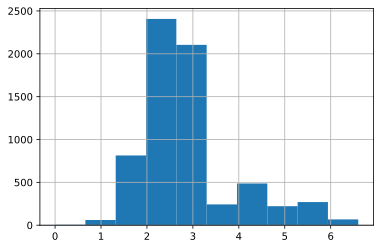

In [44]:
train['engineDisplacement'].str.partition()[0] \
.replace('undefined', '0') \
.astype('float').hist()

In [45]:
test['engineDisplacement'].value_counts(dropna=False)

2.0 LTR          501
3.0 LTR          487
1.6 LTR           83
1.8 LTR           82
4.4 LTR           69
2.5 LTR           45
3.5 LTR           42
5.5 LTR           41
2.1 LTR           40
4.0 LTR           32
4.7 LTR           28
1.4 LTR           24
4.2 LTR           23
2.8 LTR           17
4.8 LTR           16
5.0 LTR           14
2.2 LTR           14
1.5 LTR           12
3.2 LTR           11
2.3 LTR            9
6.2 LTR            9
6.0 LTR            7
2.9 LTR            7
1.2 LTR            7
2.4 LTR            6
5.4 LTR            6
3.6 LTR            5
3.1 LTR            5
4.1 LTR            4
1.7 LTR            4
5.2 LTR            3
3.7 LTR            3
2.7 LTR            2
1.3 LTR            2
5.8 LTR            2
2.6 LTR            2
1.9 LTR            1
4.3 LTR            1
0.7 LTR            1
5.9 LTR            1
6.6 LTR            1
3.8 LTR            1
undefined LTR      1
Name: engineDisplacement, dtype: int64

In [46]:
train['enginePower'].value_counts(dropna=False)

184 N12    602
249 N12    531
190 N12    343
306 N12    282
245 N12    274
          ... 
430 N12      1
329 N12      1
165 N12      1
609 N12      1
626 N12      1
Name: enginePower, Length: 146, dtype: int64

In [47]:
# Change engine power to normal view
train['enginePower'].str.partition()[0].astype('int').value_counts(dropna=False)

184    602
249    531
190    343
306    282
245    274
      ... 
457      1
329      1
165      1
480      1
100      1
Name: 0, Length: 146, dtype: int64

In [48]:
test['enginePower'].value_counts(dropna=False)

184 N12    157
249 N12    124
245 N12     81
190 N12     77
211 N12     66
          ... 
110 N12      1
487 N12      1
238 N12      1
132 N12      1
445 N12      1
Name: enginePower, Length: 120, dtype: int64

In [49]:
train['fuelType'].value_counts(dropna=False)

бензин     4803
дизель     1861
гибрид       12
электро       5
Name: fuelType, dtype: int64

In [50]:
test['fuelType'].value_counts(dropna=False)

бензин     1214
дизель      454
гибрид        2
электро       1
Name: fuelType, dtype: int64

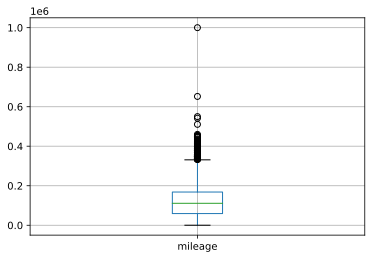

In [51]:
train.boxplot('mileage')

In [52]:
train[train['mileage'] >900000]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
1922,родстер,MERCEDES,чёрный,Рейстайлинг. \nОдин хозяин по ПТС. Оригинальны...,1.8 LTR,184 N12,бензин,999999,2008,SLK_KLASSE,...,877000.0,2008,1088341590,ROADSTER AUTOMATIC 1.8,автоматическая,1 владелец,10 лет и 11 месяцев,Оригинал,задний,Левый


Strange mileage, see the description

In [53]:
train.loc[1922].description

'Рейстайлинг. \nОдин хозяин по ПТС. Оригинальный пробег 98500 км.\n\nСостояние Очень Хорошее ! \nСделано ТО + замена масла в АКПП\nНовая резина !\n\nТехнически и юридически безупречен.\n \nКуплен в августа 2009 , \nБережная эксплуатация и своевременная замена всех расходников. \nВсе системы работают исправно. \nДва ключа. \nМосковские с номера. \nАВТОМОБИЛЬ НЕ ТРЕБУЕТ ВЛОЖЕНИЙ. \nКожанны салон\nПодушки безопасности \nABS EBD ESP \nПарктроник \nТеплый шарф.\nОхранная система \nИммобилайзер \nЦентральный замок\nДатчик света \nДатчик дождя \nОмыватель фар \nКсеноновые фары \nБортовой компьютер \nКруиз контроль \nМультируль \nЭлектропривод богажника \nЭлектрические зеркала с обогревом \nОбогрев сидений \nКлимат контроль 2-зонный \nПротивотуманные фары\nПосредникам, автосалонам и рекламным агентам - просьба не беспокоить.\nТорг.'

In [54]:
train['mileage'].replace({999999:98500}, inplace=True)

25-й перцентиль: 800000.0, 75-й перцентиль: 2299711.0, IQR: 1499711.0,  Границы выбросов: [-1449566.5, 4549277.5].


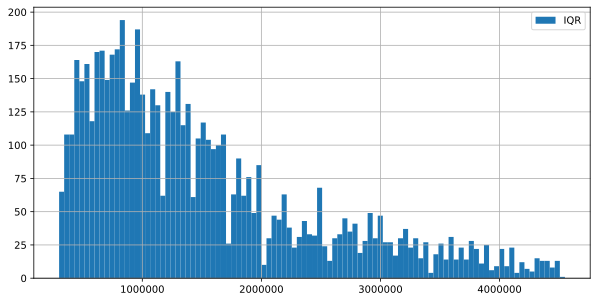

In [55]:
median = train.price.median()
IQR = train.price.quantile(0.75) - train.price.quantile(0.25)
perc25 = train.price.quantile(0.25)
perc75 = train.price.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

rcParams['figure.figsize'] = 10, 5

train.price.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 100, label = 'IQR').ticklabel_format(style='plain')
#plt.ax.ticklabel_format(useOffset=False)
plt.legend();

As can be seen from the statistics and the graph, most prices are distributed between 800K and 2.3 M (median 1.9 M, 25th percentile 800K and 75th-2.3 M). The data is not balanced, and there are outliers (for example, the maximum value is almost 25 M). Let's take a closer look at price for emissions.

Filter the data according to the resulting statistics:

In [56]:
train = train.loc[train.price.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]

print('Размер тренировочной выборки:', train.shape)
print('Текущая пропорция test/train:', round((test.shape[0] / train.shape[0]), 2))

Размер тренировочной выборки: (6233, 22)
Текущая пропорция test/train: 0.27


In [57]:
train['model_info'].value_counts(dropna=False)

5ER               609
3ER               465
E_KLASSE          409
X5                378
A6                358
                 ... 
None                1
CITAN               1
SLC_KLASSE_AMG      1
W201                1
I8                  1
Name: model_info, Length: 108, dtype: int64

In [58]:
test['model_info'].value_counts(dropna=False)

5ER               165
3ER               112
X5                104
E_KLASSE           80
A6                 75
                 ... 
M4                  1
TTS                 1
CL_KLASSE_AMG       1
CLA_KLASSE_AMG      1
SLR_KLASSE          1
Name: model_info, Length: 101, dtype: int64

In [59]:
train['name'].value_counts(dropna=False)

200 2.0 AT (184 л.с.)        121
35i 3.0 AT (306 л.с.) 4WD    116
2.0 AMT (211 л.с.) 4WD       113
400 3.0 AT (333 л.с.) 4WD     71
2.0 AMT (249 л.с.) 4WD        65
                            ... 
220 2.2 AT (150 л.с.)          1
28i 2.0 AT (245 л.с.)          1
420i 2.0 MT (184 л.с.)         1
645i 4.4 MT (333 л.с.)         1
2.5 AMT (367 л.с.) 4WD         1
Name: name, Length: 844, dtype: int64

In [60]:
test['name'].value_counts(dropna=False)

35i 3.0 AT (306 л.с.) 4WD            35
2.0 AMT (211 л.с.) 4WD               32
30d 3.0d AT (249 л.с.) 4WD           22
400 3.0 AT (333 л.с.) 4WD            21
520i 2.0 AT (184 л.с.)               21
                                     ..
340i xDrive 3.0 AT (326 л.с.) 4WD     1
380 3.8 AT (204 л.с.)                 1
2.0 AT (211 л.с.) 4WD                 1
3.0d AT (250 л.с.) 4WD                1
300 3.5 AT (249 л.с.)                 1
Name: name, Length: 536, dtype: int64

In [61]:
# Change name to normal view
train['name'].str.partition()[0].value_counts(dropna=False)

2.0          471
200          392
350          374
1.8          204
500          195
            ... 
380            1
xDrive18d      1
S              1
745d           1
1.9            1
Name: 0, Length: 216, dtype: int64

In [62]:
test['name'].str.partition()[0].value_counts(dropna=False)

2.0     120
350     108
200      84
1.8      54
3.0d     52
       ... 
2.3       1
GT        1
220i      1
430       1
1.9       1
Name: 0, Length: 166, dtype: int64

In [63]:
train['numberOfDoors'].value_counts(dropna=False)

5    2834
4    2797
2     560
3      42
Name: numberOfDoors, dtype: int64

In [64]:
test['numberOfDoors'].value_counts(dropna=False)

5    764
4    713
2    175
3     19
Name: numberOfDoors, dtype: int64

In [65]:
train['productionDate'].value_counts(dropna=False)

2013    629
2011    559
2012    538
2014    534
2015    455
2016    435
2008    418
2017    385
2010    371
2018    326
2009    281
2007    269
2019    224
2005    146
2006    144
2004    117
2003     85
2002     61
2001     53
2000     33
2020     32
1999     32
1998     18
1997     14
1995     12
1994     11
1996     10
1993      9
1992      8
1990      6
1988      4
1985      3
1986      3
1983      2
1982      2
1984      2
1989      1
1987      1
Name: productionDate, dtype: int64

In [66]:
train['vehicleConfiguration'].value_counts(dropna=False)

ALLROAD_5_DOORS AUTOMATIC 3.0    935
SEDAN AUTOMATIC 2.0              744
SEDAN AUTOMATIC 3.0              462
ALLROAD_5_DOORS AUTOMATIC 2.0    407
ALLROAD_5_DOORS ROBOT 2.0        176
                                ... 
COUPE MECHANICAL 2.8               1
COUPE_HARDTOP AUTOMATIC 2.6        1
CABRIO ROBOT 5.0                   1
PICKUP_TWO AUTOMATIC 3.0           1
ALLROAD_OPEN AUTOMATIC 5.0         1
Name: vehicleConfiguration, Length: 278, dtype: int64

In [67]:
# Change vehicle configuration to normal view
train['vehicleConfiguration'].str.rpartition()[0].value_counts(dropna=False)

SEDAN AUTOMATIC                 2121
ALLROAD_5_DOORS AUTOMATIC       1866
SEDAN ROBOT                      303
SEDAN VARIATOR                   238
COUPE AUTOMATIC                  223
ALLROAD_5_DOORS ROBOT            222
HATCHBACK_5_DOORS ROBOT          144
HATCHBACK_5_DOORS AUTOMATIC      120
LIFTBACK ROBOT                   119
MINIVAN AUTOMATIC                113
LIFTBACK AUTOMATIC               100
COUPE ROBOT                       98
COUPE_HARDTOP AUTOMATIC           90
WAGON_5_DOORS AUTOMATIC           88
SEDAN MECHANICAL                  60
ROADSTER AUTOMATIC                45
COUPE VARIATOR                    33
CABRIO AUTOMATIC                  31
WAGON_5_DOORS VARIATOR            23
WAGON_5_DOORS ROBOT               23
HATCHBACK_3_DOORS AUTOMATIC       21
COUPE MECHANICAL                  21
HATCHBACK_3_DOORS ROBOT           18
HATCHBACK_5_DOORS VARIATOR        18
WAGON_5_DOORS MECHANICAL          15
LIFTBACK VARIATOR                 12
MINIVAN MECHANICAL                10
H

In [68]:
test['vehicleConfiguration'].value_counts(dropna=False)

ALLROAD_5_DOORS AUTOMATIC 3.0     262
SEDAN AUTOMATIC 2.0               195
SEDAN AUTOMATIC 3.0               131
ALLROAD_5_DOORS AUTOMATIC 2.0     111
ALLROAD_5_DOORS ROBOT 2.0          50
                                 ... 
WAGON_5_DOORS MECHANICAL 1.8        1
COUPE MECHANICAL 2.3                1
HATCHBACK_5_DOORS VARIATOR 2.0      1
HATCHBACK_5_DOORS ROBOT 1.3         1
ROADSTER AUTOMATIC 3.7              1
Name: vehicleConfiguration, Length: 205, dtype: int64

In [69]:
train['vehicleTransmission'].value_counts(dropna=False)

автоматическая      4838
роботизированная     936
вариатор             325
механическая         134
Name: vehicleTransmission, dtype: int64

In [70]:
test['vehicleTransmission'].value_counts(dropna=False)

автоматическая      1299
роботизированная     242
вариатор              81
механическая          49
Name: vehicleTransmission, dtype: int64

In [71]:
train['Владельцы'].value_counts(dropna=False)

3 или более    2607
2 владельца    1904
1 владелец     1722
Name: Владельцы, dtype: int64

In [72]:
test['Владельцы'].value_counts(dropna=False)

3 или более    665
2 владельца    509
1 владелец     497
Name: Владельцы, dtype: int64

In [73]:
train['Владение'].value_counts(dropna=False)

NaN                   4023
1 год и 8 месяцев       48
1 год и 2 месяца        47
1 год                   42
1 год и 5 месяцев       42
                      ... 
11 лет и 6 месяцев       1
11 лет                   1
14 лет и 5 месяцев       1
17 лет                   1
16 лет и 4 месяца        1
Name: Владение, Length: 172, dtype: int64

In [74]:
test['Владение'].value_counts(dropna=False)

NaN                   1092
1 год и 2 месяца        14
3 года                  13
8 месяцев               13
1 год и 8 месяцев       13
                      ... 
13 лет и 1 месяц         1
9 лет и 3 месяца         1
8 лет и 7 месяцев        1
8 лет и 6 месяцев        1
10 лет и 6 месяцев       1
Name: Владение, Length: 132, dtype: int64

In [75]:
display(train['ПТС'].value_counts(dropna=False))
test['ПТС'].value_counts(dropna=False)

Оригинал    5532
Дубликат     701
Name: ПТС, dtype: int64

Оригинал    1504
Дубликат     167
Name: ПТС, dtype: int64

In [76]:
display(train['Привод'].value_counts(dropna=False))
test['Привод'].value_counts(dropna=False)

полный      3780
задний      1750
передний     703
Name: Привод, dtype: int64

полный      1029
задний       469
передний     173
Name: Привод, dtype: int64

In [77]:
display(train['Руль'].value_counts(dropna=False))
test['Руль'].value_counts(dropna=False)

Левый     6231
Правый       2
Name: Руль, dtype: int64

Левый    1671
Name: Руль, dtype: int64

We will perform a quick analysis of the data in order to understand whether our algorithm can work with this data.

Let's see what the distributions of numeric features look like:

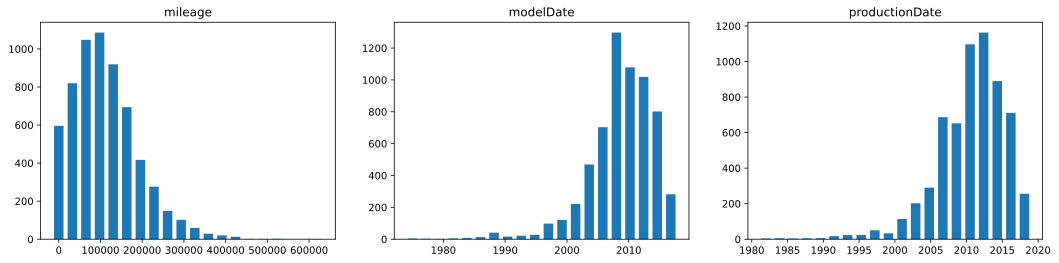

In [78]:
# let's see what the distributions of numeric features look like
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

# PreProc Tabular Data

In [79]:
# Month of ownership
def num_of_months(row):
    if pd.notnull(row):
        list_ownership = row.split()
        if len(list_ownership) == 2:
            if list_ownership[1] in ['год', 'года', 'лет']:
                return int(list_ownership[0])*12
            return int(list_ownership[0])
        return int(list_ownership[0])*12 + int(list_ownership[3])

In [80]:
# statistic column
def agg_func(data, col, agg):
    rep = data[data['sample'] == 1].groupby(col)['price'].agg(agg).to_dict()
    data[agg+'_price_'+col] = data[col].replace(rep)

In [81]:
# trim the quantel
def nn_count(table_train=train, quartile=90):
    categorical_columns = [c for c in table_train.columns if table_train[c].
                           dtype.name == 'object']
    print(categorical_columns)
    for attrib in categorical_columns:
        col_with_freqs = list(table_train[attrib].value_counts())
        top_attrib_count = int(np.percentile(col_with_freqs, quartile))
        all_attrib = table_train[attrib].value_counts().index
        top_attrib = table_train[attrib].\
            value_counts()[table_train[attrib].
                           value_counts() > top_attrib_count].index
        attrib_to_throw_away = list(set(all_attrib) - set(top_attrib))
        table_train.loc[table_train[attrib].
                        isin(attrib_to_throw_away), attrib] = 'other'


In [82]:
# remove collinear features
def remove_collinear_features(x, threshold):
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            val = abs(item.values)
            # If correlation exceeds the threshold
            if val >= threshold:
                drop_cols.append(col.values[0])
    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)  # Prepare data for modelling
    return x

In [83]:
# IMPORTANT! for correct feature processing, we combine the train and test into one dataset
train['sample'] = 1
test['sample'] = 0
test['price'] = 0

data = test.append(train, sort=False).reset_index(drop=True)
print(train.shape, test.shape, data.shape)

(6233, 23) (1671, 23) (7904, 23)


In [84]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()

    #################### Feature Engineering ####################################################
    # Change body type to normal view
    df_output['bodyType'] = df_output['bodyType'].str.partition()[0]
    df_output['bodyType'] = df_output['bodyType'].str.lower()  
    df_output['bodyType'].replace('купе-хардтоп', 'купе', inplace=True)
    df_output['bodyType'].replace('седан-хардтоп', 'седан', inplace=True)
    # Change engine displacement to normal view
    df_output['engineDisplacement'] = df_output['engineDisplacement'].str.partition()[0]
    df_output['engineDisplacement'].replace('undefined', '0', inplace=True)
    df_output['engineDisplacement'] = df_output['engineDisplacement'].astype('float')

    # Change engine power to normal view
    df_output['enginePower'] = df_output['enginePower'].str.partition()[0]
    df_output['enginePower'] = df_output['enginePower'].astype('int')
    # Change name to normal view
    df_output['name'] = df_output['name'].str.partition()[0]
    # Change Владельцы to normal view
    df_output['Владельцы'] = df_output['Владельцы'].str[0].astype(int)
    # Change vehicle configuration to normal view
    df_output['vehicleConfiguration'] = df_output['vehicleConfiguration'].str.rpartition()[0]
    # add diler column
    df_output['description'].str.contains('дилер').value_counts(dropna=False)
    df_output['diler'] = df_output['description'].str.contains('дилер')
    df_output.replace({False: 0, True: 1}, inplace=True)
    # date difference
    df_output['prodDate_dif_modDate'] = df_output['productionDate'] - df_output['modelDate']
    # Change Владение to normal view
    df_output['Владение'] = df_output['Владение'].apply(num_of_months)
    data['Владение_is_none'] = pd.isna(data['Владение']).astype('uint8')
    df_output['Владение'].fillna(df_output['Владение'].
                                   median(), inplace=True)
    # Time from release date
    df_output['from_productionDate'] = df_output['productionDate'].rsub(2020)
    df_output['from_modelDate'] = df_output['modelDate'].rsub(2020)
    # Average mileage per year
    df_output['mileage_per_year'] = df_output.mileage.\
                                div(df_output.from_productionDate.replace(0, 1))
    # Average mileage per own
    df_output['mileage_per_own'] = df_output.mileage.div(df_output['Владельцы'])

    df_output['year_per_own'] = df_output.from_productionDate.div(df_output['Владельцы'])
    
    # removing unnecessary features for the model
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    df_output.drop(['modelDate','productionDate',], axis = 1, inplace=True)
    
    nn_count(df_output, quartile=10)  # trim the Quantel
    # add statistic columns
    agg_func(df_output, 'bodyType', 'mean')
    agg_func(df_output, 'fuelType', 'mean')
    agg_func(df_output, 'name', 'mean')
    agg_func(df_output, 'vehicleConfiguration', 'mean')
    
    agg_func(df_output, 'bodyType', 'median')
    agg_func(df_output, 'fuelType', 'median')
    agg_func(df_output, 'name', 'median')
    agg_func(df_output, 'vehicleConfiguration', 'median')

    ################### Numerical Features ############################################################## 
    categorical_features = df_output.dtypes[df_output.dtypes == 'object'].index.to_list()
    numerical_features = df_output.dtypes[df_output.dtypes != 'object'].index.to_list()
    numerical_features = set(numerical_features) - set(['price', 'sample'])
    # then fill in the blanks
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # data normalization
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = np.log1p(df_output[column])
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ##############################################################  
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    return df_output

In [85]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name', 'vehicleConfiguration', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль']


,engineDisplacement,enginePower,mileage,numberOfDoors,Владельцы,Владение,sample,price,diler,prodDate_dif_modDate,...,median_price_name_3445000.0,median_price_name_3455000.0,median_price_name_3800000.0,median_price_name_3949500.0,median_price_name_3975000.0,median_price_name_3980000.0,median_price_name_3999999.0,median_price_name_4198000.0,median_price_name_4448500.0,median_price_name_40i
3467,0.831497,0.756393,0.860347,0.736966,1.000000,0.578128,1,835000.0,0.0,0.470818,...,0,0,0,0,0,0,0,0,0,0
465,0.541682,0.400411,0.827519,0.736966,0.584963,0.578128,0,0.0,0.0,0.235409,...,0,0,0,0,0,0,0,0,0,0
453,0.507665,0.346180,0.893824,0.736966,0.584963,0.762526,0,0.0,0.0,0.470818,...,0,0,0,0,0,0,0,0,0,0
4912,0.658236,0.446614,0.809913,0.736966,1.000000,0.578128,1,1199000.0,0.0,0.373114,...,0,0,0,0,0,0,0,0,0,0
4568,0.683527,0.461727,0.869323,1.000000,0.584963,0.578128,1,850000.0,0.0,0.470818,...,0,0,0,0,0,0,0,0,0,0
1701,0.541682,0.535935,0.807526,0.736966,0.000000,0.578128,1,2349000.0,1.0,0.235409,...,0,0,0,0,0,0,0,0,0,0
6067,0.683527,0.709950,0.747975,0.736966,0.000000,0.605099,1,2850000.0,0.0,0.373114,...,0,1,0,0,0,0,0,0,0,0
5555,0.683527,0.502303,0.897345,0.736966,1.000000,0.780243,1,500000.0,0.0,0.235409,...,0,0,0,0,0,0,0,0,0,0
3617,0.695702,0.546610,0.871411,1.000000,0.584963,0.578128,1,559000.0,0.0,0.373114,...,0,0,0,0,0,0,0,0,0,0
3477,0.541682,0.400411,0.833156,0.736966,0.000000,0.578128,1,1520000.0,0.0,0.235409,...,0,0,0,0,0,0,0,0,0,0


In [86]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7904 entries, 0 to 7903
Columns: 759 entries, engineDisplacement to median_price_name_40i
dtypes: float64(20), int64(1), uint8(738)
memory usage: 6.8 MB


## Split data

In [87]:
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = np.log1p(train_data.price.values)  # target column
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [88]:
X = remove_collinear_features(X, 0.90)  # remove collinear features

In [89]:
X_sub = X_sub[X.columns]

In [90]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6233 entries, 1671 to 7903
Columns: 405 entries, engineDisplacement to median_price_name_40i
dtypes: float64(16), uint8(389)
memory usage: 3.1 MB


# Model 2: CatBoostRegressor

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [92]:
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
#                           task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose=False,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [93]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.39%


In [94]:
feature_importance = pd.Series(model.feature_importances_,index=X_train.columns).fillna(0).sort_values(ascending=False)
feature_importance

from_productionDate         25.964386
from_modelDate              19.638446
enginePower                 13.076912
engineDisplacement           9.660165
mileage                      8.217611
                              ...    
model_info_2ACTIVETOURER     0.000000
name_Electro                 0.000000
model_info_2GRANDTOURER      0.000000
name_8tiptronic              0.000000
median_price_name_40i        0.000000
Length: 405, dtype: float64

In [95]:
col = feature_importance[feature_importance>0].index

In [96]:
X_train[col]

,from_productionDate,from_modelDate,enginePower,engineDisplacement,mileage,mean_price_fuelType,mean_price_bodyType,model_info_G_KLASSE,mean_price_vehicleConfiguration,mileage_per_year,...,model_info_CLA_KLASSE_AMG,model_info_GLE_KLASSE_AMG,name_728i,name_645i,name_218i,name_35d,name_1.9,name_4.8i,model_info_M4,model_info_RS5
3903,0.678276,0.581508,0.551854,0.683527,0.851252,0.000000,0.505030,0,0.629119,0.813605,...,0,0,0,0,0,0,0,0,0,0
6927,0.720353,0.604531,0.326546,0.541682,0.882863,0.000000,0.000000,0,0.356799,0.836582,...,0,0,0,0,0,0,0,0,0,0
3170,0.531153,0.389193,0.461727,0.541682,0.828971,0.000000,0.505030,0,0.629119,0.842702,...,0,0,0,0,0,0,0,0,0,0
7164,0.299875,0.284662,0.535935,0.541682,0.756587,0.000000,0.505030,0,0.629119,0.856496,...,0,0,0,0,0,0,0,0,0,0
3868,0.628510,0.500000,0.400411,0.541682,0.868536,0.685606,0.000000,0,0.356799,0.853248,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5443,0.567601,0.500000,0.648449,0.683527,0.817601,0.000000,0.000000,0,0.356799,0.814570,...,0,0,0,0,0,0,0,0,0,0
6862,0.599751,0.529610,0.786267,0.858155,0.809249,0.000000,0.625171,0,0.599543,0.792023,...,0,0,0,0,0,0,0,0,0,0
6897,0.654526,0.556641,0.400411,0.507665,0.836495,0.000000,0.505030,0,0.629119,0.804485,...,0,0,0,0,0,0,0,0,0,0
7061,0.628510,0.500000,0.446614,0.507665,0.817343,0.000000,0.168793,0,0.479431,0.790950,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# delete not important features
X_train = X_train[col]
X_test = X_test[col]
X_sub = X_sub[col]

In [98]:
model = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          # learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose=False,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [99]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.32%


### Submission

In [100]:
sub_predict_catboost = model.predict(X_sub[col])
sample_submission['price'] = np.exp(sub_predict_catboost)
sample_submission.to_csv('catboost_submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,7.077348e+05
1,1096405886,2.798338e+06
2,1100195294,6.121890e+05
3,1099827282,4.907704e+05
4,1100076198,2.651738e+06


# Model 3: Tabular NN

Построим обычную сеть:

In [101]:
X_train.head(5)

,from_productionDate,from_modelDate,enginePower,engineDisplacement,mileage,mean_price_fuelType,mean_price_bodyType,model_info_G_KLASSE,mean_price_vehicleConfiguration,mileage_per_year,...,model_info_CLA_KLASSE_AMG,model_info_GLE_KLASSE_AMG,name_728i,name_645i,name_218i,name_35d,name_1.9,name_4.8i,model_info_M4,model_info_RS5
3903,0.678276,0.581508,0.551854,0.683527,0.851252,0.000000,0.50503,0,0.629119,0.813605,...,0,0,0,0,0,0,0,0,0,0
6927,0.720353,0.604531,0.326546,0.541682,0.882863,0.000000,0.00000,0,0.356799,0.836582,...,0,0,0,0,0,0,0,0,0,0
3170,0.531153,0.389193,0.461727,0.541682,0.828971,0.000000,0.50503,0,0.629119,0.842702,...,0,0,0,0,0,0,0,0,0,0
7164,0.299875,0.284662,0.535935,0.541682,0.756587,0.000000,0.50503,0,0.629119,0.856496,...,0,0,0,0,0,0,0,0,0,0
3868,0.628510,0.500000,0.400411,0.541682,0.868536,0.685606,0.00000,0,0.356799,0.853248,...,0,0,0,0,0,0,0,0,0,0


## Simple Dense NN

In [102]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))  # change activation
model.add(L.Dropout(0.2))  # Dropout parameters selected
model.add(L.BatchNormalization())  # add normalization
model.add(L.Dense(256, activation="sigmoid"))  # change activation
model.add(L.Dropout(0.2))  # Dropout parameters selected
model.add(L.BatchNormalization())  # add normalization
model.add(L.Dense(1, activation="linear"))

In [103]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               171520    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [104]:
# Compile model
# Add the conditions on the lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [105]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [106]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

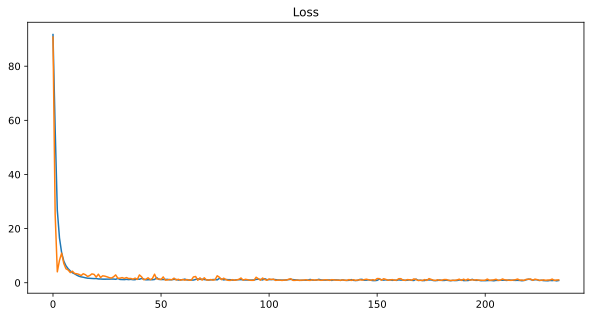

In [107]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [108]:
model.load_weights('best_model.hdf5')
model.save('nn_1.hdf5')

In [109]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn1[:,0])))*100:0.2f}%")

TEST mape: 13.37%


In [110]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_nn1[:,0])
sample_submission.to_csv('nn1_submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,3.588216e+05
1,1096405886,2.517674e+06
2,1100195294,5.609691e+05
3,1099827282,4.010235e+05
4,1100076198,2.462548e+06


# Model 4: NLP + Multiple Inputs

In [111]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
7899    Продаётся любимый автомобиль! За годы эксплуат...
7900    Куплена у официального дилера в 2017 г. \n\nТр...
7901    Торг на месте. Все работает. Сборка немецкая. ...
7902    Автомобиль в отличном состоянии.\n3-из Авто в ...
7903    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 7904, dtype: object

In [112]:
# creating a dictionary of stop words to clear the attribute
nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")
# morph = MorphAnalyzer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
russian_stopwords = set(russian_stopwords) - set(['не', 'была', 'без'])
# russian_stopwords

In [114]:
# clearing fields with descriptions of punctuation marks and numbers
def text_prep(x):
    x = ' '.join([word for word in x.split() if word not in (russian_stopwords)]) #очищаю строки от стоп-слов
    return x


data['description'] = data['description'].str.replace(r'(\W|\d)', ' ').str.replace(r'(\s+)', ' ')
data['description']=data['description'].apply(text_prep)

In [115]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [116]:
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [117]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.36 s, sys: 3.34 ms, total: 1.37 s
Wall time: 1.37 s


In [118]:
# tokenize.word_index

In [119]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5298, 256) (935, 256) (1671, 256)
CPU times: user 1.23 s, sys: 4.58 ms, total: 1.23 s
Wall time: 1.23 s


In [120]:
# this is what our text looks like now
print(text_train.iloc[6])
print(text_train_sequences[6])

Машина отличном состоянии без аварий ДТП Салонам перекупам не звонить не писать
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   

### RNN NLP

In [121]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid"))
model_nlp.add(L.Dropout(0.5))

### MLP

In [122]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.2))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dense(256, activation="sigmoid"))
model_mlp.add(L.Dropout(0.2))
model_mlp.add(L.BatchNormalization())

### Multiple Inputs NN

In [123]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(128, activation="sigmoid")(combinedInput)
head = L.Dropout(0.2)(head)
head = L.BatchNormalization()(head)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [124]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     7926016     seq_description[0][0]            
__________________________________________________________________________________________________
dense_4_input (InputLayer)      [(None, 334)]        0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
_______________________________________________________________________________________

### Fit

In [125]:
# Add the conditions on the lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [126]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=40, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [127]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 4s 358ms/step - loss: 96.5266 - MAPE: 96.5266 - val_loss: 68.3213 - val_MAPE: 68.3213
Epoch 2/500
11/11 [==============================] - 4s 322ms/step - loss: 86.4720 - MAPE: 86.4720 - val_loss: 20.6186 - val_MAPE: 20.6186
Epoch 3/500
11/11 [==============================] - 3s 289ms/step - loss: 70.8259 - MAPE: 70.8259 - val_loss: 5.2751 - val_MAPE: 5.2751
Epoch 4/500
11/11 [==============================] - 3s 289ms/step - loss: 47.1294 - MAPE: 47.1294 - val_loss: 44.1175 - val_MAPE: 44.1175
Epoch 5/500
11/11 [==============================] - 3s 296ms/step - loss: 19.4145 - MAPE: 19.4145 - val_loss: 75.4559 - val_MAPE: 75.4559
Epoch 6/500
11/11 [==============================] - 3s 297ms/step - loss: 14.9009 - MAPE: 14.9009 - val_loss: 56.9294 - val_MAPE: 56.9294
Epoch 7/500
11/11 [==============================] - 3s 285ms/step - loss: 10.9055 - MAPE: 10.9055 - val_loss: 35.0193 - val_MAPE: 35.0193
Epoch 8/500
11/11 [==========

Epoch 61/500
11/11 [==============================] - 3s 287ms/step - loss: 1.1160 - MAPE: 1.1160 - val_loss: 0.9524 - val_MAPE: 0.9524
Epoch 62/500
11/11 [==============================] - 3s 291ms/step - loss: 1.2071 - MAPE: 1.2071 - val_loss: 0.9862 - val_MAPE: 0.9862
Epoch 63/500
11/11 [==============================] - 3s 285ms/step - loss: 1.0981 - MAPE: 1.0981 - val_loss: 1.1244 - val_MAPE: 1.1244
Epoch 64/500
11/11 [==============================] - 3s 290ms/step - loss: 1.0073 - MAPE: 1.0073 - val_loss: 1.1183 - val_MAPE: 1.1183
Epoch 65/500
11/11 [==============================] - 3s 288ms/step - loss: 0.9902 - MAPE: 0.9902 - val_loss: 0.9498 - val_MAPE: 0.9498
Epoch 66/500
11/11 [==============================] - 3s 288ms/step - loss: 0.9789 - MAPE: 0.9789 - val_loss: 1.1110 - val_MAPE: 1.1110
Epoch 67/500
11/11 [==============================] - 3s 296ms/step - loss: 0.9654 - MAPE: 0.9654 - val_loss: 0.9709 - val_MAPE: 0.9709
Epoch 68/500
11/11 [============================

11/11 [==============================] - 3s 286ms/step - loss: 0.8586 - MAPE: 0.8586 - val_loss: 0.8517 - val_MAPE: 0.8517
Epoch 122/500
11/11 [==============================] - 3s 309ms/step - loss: 0.8821 - MAPE: 0.8821 - val_loss: 1.0148 - val_MAPE: 1.0148
Epoch 123/500
11/11 [==============================] - 3s 276ms/step - loss: 0.9057 - MAPE: 0.9057 - val_loss: 0.9260 - val_MAPE: 0.9260
Epoch 124/500
11/11 [==============================] - 3s 281ms/step - loss: 0.8418 - MAPE: 0.8418 - val_loss: 0.8614 - val_MAPE: 0.8614
Epoch 125/500
11/11 [==============================] - 3s 300ms/step - loss: 0.8266 - MAPE: 0.8266 - val_loss: 0.8562 - val_MAPE: 0.8562
Epoch 126/500
11/11 [==============================] - 3s 285ms/step - loss: 0.8611 - MAPE: 0.8611 - val_loss: 0.8710 - val_MAPE: 0.8710
Epoch 127/500
11/11 [==============================] - 3s 310ms/step - loss: 0.8956 - MAPE: 0.8956 - val_loss: 1.0015 - val_MAPE: 1.0015
Epoch 128/500
11/11 [==============================] - 

Epoch 181/500
11/11 [==============================] - 3s 284ms/step - loss: 0.7911 - MAPE: 0.7911 - val_loss: 0.9359 - val_MAPE: 0.9359
Epoch 182/500
11/11 [==============================] - 3s 286ms/step - loss: 0.8649 - MAPE: 0.8649 - val_loss: 0.8973 - val_MAPE: 0.8973


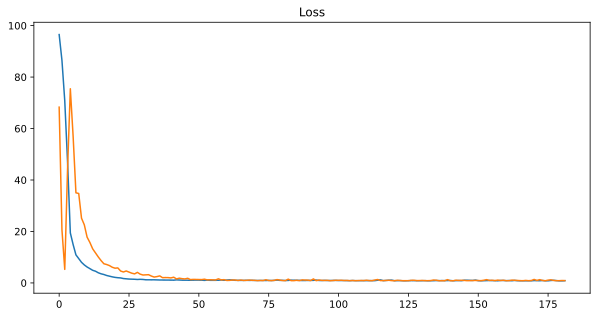

In [128]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [129]:
model.load_weights('best_model.hdf5')
model.save('nn_mlp_nlp.hdf5')

In [130]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn2[:,0])))*100:0.2f}%")

TEST mape: 12.58%


In [131]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = np.exp(sub_predict_nn2[:,0])
sample_submission.to_csv('nn2_submission.csv', index=False)
sample_submission.head()

,sell_id,price
0,1099427284,4.299865e+05
1,1096405886,2.828753e+06
2,1100195294,7.700234e+05
3,1099827282,5.134415e+05
4,1100076198,2.730210e+06


# Model 5: Добавляем картинки

### Data

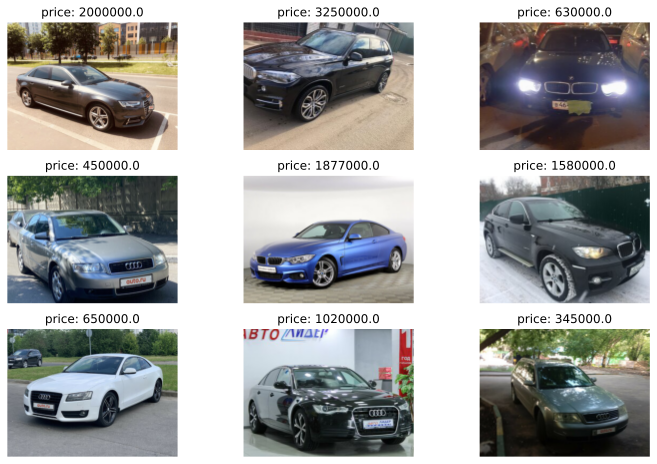

In [133]:
# make sure that the prices and photos are uploaded correctly
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [134]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5298, 240, 320, 3) dtype uint8
images shape (935, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

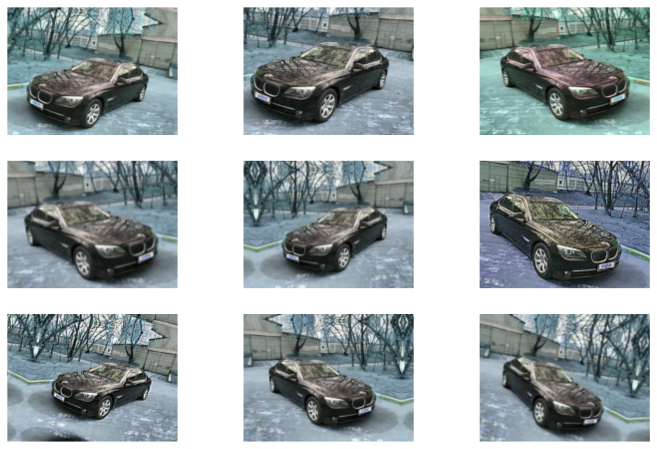

In [135]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
        # ISONoise(),
    ], p=0.4),
    OneOf([
        MotionBlur(p=0.2),
        # GaussianBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.3),
    ShiftScaleRotate(shift_limit=0.0625,
                     scale_limit=0.2,
                     rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.3),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.4),
    HueSaturationValue(p=0.3),
], p=1)


plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [136]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
        augment_dict = augmentation(image = images[i])
        augmented_image = augment_dict['image']
        augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [137]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [138]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

# check that there are no errors (an exception will not be thrown):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [139]:
# chose EfficientNetB4
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

71688192/71686520 [==============================] - 1s 0us/step


In [140]:
# building a neural network for analyzing tabular data
tabular_model = Sequential([
    L.Input(shape = X_train.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.Dropout(0.2),
    L.BatchNormalization(),
    L.Dense(256, activation = 'sigmoid'),
    L.Dropout(0.2),
    L.BatchNormalization(),
    ])

In [141]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.BatchNormalization(),
    L.LSTM(128),
    L.Dropout(0.5),
    L.BatchNormalization(),
    L.Dense(64, activation="sigmoid"),
    L.Dropout(0.5),
    L.BatchNormalization(),
    ])

In [142]:
# combining the outputs of three neural networks
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="sigmoid")(combinedInput)
head = L.Dropout(0.5)(head)
head = L.BatchNormalization()(head)
head = L.Dense(128, activation="sigmoid")(head)
head = L.Dropout(0.5)(head)
head = L.BatchNormalization()(head)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
# model.summary()

In [143]:
# Add the conditions on the lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [144]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=15, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [145]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
177/177 [==============================] - 161s 911ms/step - loss: 77.1132 - MAPE: 77.1132 - val_loss: 199.1713 - val_MAPE: 199.1713
Epoch 2/100
177/177 [==============================] - 155s 876ms/step - loss: 24.2764 - MAPE: 24.2764 - val_loss: 16.3131 - val_MAPE: 16.3131
Epoch 3/100
177/177 [==============================] - 154s 872ms/step - loss: 16.0649 - MAPE: 16.0649 - val_loss: 4.0090 - val_MAPE: 4.0090
Epoch 4/100
177/177 [==============================] - 158s 890ms/step - loss: 13.0848 - MAPE: 13.0848 - val_loss: 3.6600 - val_MAPE: 3.6600
Epoch 5/100
177/177 [==============================] - 154s 870ms/step - loss: 10.4623 - MAPE: 10.4623 - val_loss: 2.5348 - val_MAPE: 2.5348
Epoch 6/100
177/177 [==============================] - 154s 870ms/step - loss: 8.8239 - MAPE: 8.8239 - val_loss: 3.3432 - val_MAPE: 3.3432
Epoch 7/100
177/177 [==============================] - 156s 881ms/step - loss: 7.4346 - MAPE: 7.4346 - val_loss: 1.9183 - val_MAPE: 1.9183
Epoch 8/100

177/177 [==============================] - 158s 895ms/step - loss: 1.3340 - MAPE: 1.3340 - val_loss: 1.0500 - val_MAPE: 1.0500
Epoch 60/100
177/177 [==============================] - 162s 917ms/step - loss: 1.3233 - MAPE: 1.3233 - val_loss: 1.0467 - val_MAPE: 1.0467
Epoch 61/100
177/177 [==============================] - 159s 901ms/step - loss: 1.3270 - MAPE: 1.3270 - val_loss: 1.0585 - val_MAPE: 1.0585
Epoch 62/100
177/177 [==============================] - 159s 898ms/step - loss: 1.2914 - MAPE: 1.2914 - val_loss: 1.0735 - val_MAPE: 1.0735
Epoch 63/100
177/177 [==============================] - 161s 908ms/step - loss: 1.3138 - MAPE: 1.3138 - val_loss: 1.0970 - val_MAPE: 1.0970
Epoch 64/100
177/177 [==============================] - 162s 913ms/step - loss: 1.3054 - MAPE: 1.3054 - val_loss: 1.0484 - val_MAPE: 1.0484
Epoch 65/100
177/177 [==============================] - 158s 891ms/step - loss: 1.3082 - MAPE: 1.3082 - val_loss: 0.9954 - val_MAPE: 0.9954
Epoch 66/100
177/177 [===========

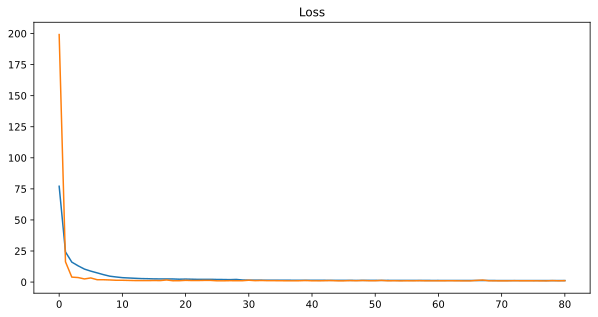

In [146]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [147]:
model.load_weights('best_model.hdf5')
model.save('nn_final.hdf5')

In [148]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn3[:,0])))*100:0.2f}%")

TEST mape: 16.87%


In [149]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = np.exp(sub_predict_nn3[:,0])
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

In [150]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(blend_predict)))*100:0.2f}%")

TEST mape: 12.74%


In [151]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = np.exp(blend_sub_predict)
sample_submission.to_csv('blend_submission.csv', index=False)

# Model Bonus: проброс признака

In [152]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.2))
model_mlp.add(L.BatchNormalization())
model_mlp.add(L.Dense(256, activation="sigmoid"))
model_mlp.add(L.Dropout(0.2))
model_mlp.add(L.BatchNormalization())

In [153]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="from_productionDate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.from_productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate = L.Flatten()(emb_productiondate)

In [154]:
combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# being our regression head
head = L.Dense(64, activation="sigmoid")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [155]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_14_input (InputLayer)     [(None, 334)]        0                                            
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          171520      dense_14_input[0][0]             
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 512)          0           dense_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 512)          2048        dropout_15[0][0]                 
_______________________________________________________________________________________

In [156]:
# Add the conditions on the lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [157]:
history = model.fit([X_train, X_train.from_productionDate.values], y_train,
                    batch_size=512,
                    epochs=500,
                    validation_data=([X_test, X_test.from_productionDate.values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
11/11 [==============================] - 0s 32ms/step - loss: 84.4308 - MAPE: 84.4308 - val_loss: 51.4285 - val_MAPE: 51.4285
Epoch 2/500
11/11 [==============================] - 0s 12ms/step - loss: 32.2862 - MAPE: 32.2862 - val_loss: 8.6700 - val_MAPE: 8.6700
Epoch 3/500
11/11 [==============================] - 0s 13ms/step - loss: 6.5023 - MAPE: 6.5023 - val_loss: 8.5651 - val_MAPE: 8.5651
Epoch 4/500
11/11 [==============================] - 0s 13ms/step - loss: 4.5468 - MAPE: 4.5468 - val_loss: 4.1175 - val_MAPE: 4.1175
Epoch 5/500
11/11 [==============================] - 0s 13ms/step - loss: 3.3849 - MAPE: 3.3849 - val_loss: 4.0603 - val_MAPE: 4.0603
Epoch 6/500
11/11 [==============================] - 0s 13ms/step - loss: 2.5279 - MAPE: 2.5279 - val_loss: 3.3727 - val_MAPE: 3.3727
Epoch 7/500
11/11 [==============================] - 0s 12ms/step - loss: 2.0282 - MAPE: 2.0282 - val_loss: 3.5712 - val_MAPE: 3.5712
Epoch 8/500
11/11 [==============================] - 0s 

Epoch 62/500
11/11 [==============================] - 0s 16ms/step - loss: 0.7989 - MAPE: 0.7989 - val_loss: 0.9061 - val_MAPE: 0.9061
Epoch 63/500
11/11 [==============================] - 0s 12ms/step - loss: 0.7984 - MAPE: 0.7984 - val_loss: 0.9645 - val_MAPE: 0.9645
Epoch 64/500
11/11 [==============================] - 0s 11ms/step - loss: 0.7527 - MAPE: 0.7527 - val_loss: 1.1963 - val_MAPE: 1.1963
Epoch 65/500
11/11 [==============================] - 0s 15ms/step - loss: 0.8057 - MAPE: 0.8057 - val_loss: 1.0210 - val_MAPE: 1.0210
Epoch 66/500
11/11 [==============================] - 0s 12ms/step - loss: 0.7876 - MAPE: 0.7876 - val_loss: 0.9122 - val_MAPE: 0.9122
Epoch 67/500
11/11 [==============================] - 0s 13ms/step - loss: 0.7706 - MAPE: 0.7706 - val_loss: 0.8823 - val_MAPE: 0.8823
Epoch 68/500
11/11 [==============================] - 0s 12ms/step - loss: 0.8666 - MAPE: 0.8666 - val_loss: 0.9234 - val_MAPE: 0.9234
Epoch 69/500
11/11 [==============================] - 0

In [158]:
model.load_weights('best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, X_test.from_productionDate.values])
print(f"TEST mape: {(mape(np.exp(y_test), np.exp(test_predict_nn_bonus[:,0])))*100:0.2f}%")

TEST mape: 12.37%
